In [588]:
# prepares the notebook for "inline" graphing, and imports matplotlib library
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from operator import attrgetter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from os.path import isfile, join

In [589]:
# These functions are used for data analysis.

# these functions are used in determining the type
# of data we are looking at (posthresh, neghold etc)
def isIncreasing(L):
    return L[0] < L[len(L) - 1]
def isDecreasing(L):
    return L[0] > L[len(L) - 1]
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of voltages and currents as arguments
def sortIntoSide(voltage, current):
    if isIncreasing(voltage) and isIncreasing(current):
        return "posThresh"
    elif isDecreasing(voltage) and isDecreasing(current):
        return "posHold"
    elif isDecreasing(voltage) and isIncreasing(current):
        return "negThresh"
    elif isIncreasing(voltage) and isDecreasing(current):
        return "negHold"
    else: 
        print("???")

In [590]:
# this will take a file name and device size and
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, file_path):
        self.pos_hold_voltages = []
        self.neg_hold_voltages = []

        self.pos_thresh_voltages = []
        self.neg_thresh_voltages = []

        self.filePath = file_path
        self.get_file_name_from_path()
        self.get_device_number_from_name()
        self.get_sample_number_from_name()
        self.read_all_data()
        self.break_into_runs()
        self.sort_runs_into_neg_pos_thresh_hold()

        # self.sort_runs_into_neg_pos_thresh_hold()

        # self.graph_all_data()

    def get_file_name_from_path(self):
        self.file_name = self.filePath.split("/GitHub/")[1]

    def get_device_number_from_name(self):
        self.device_number = self.file_name.split("_")[4]

    def get_sample_number_from_name(self):
        self.sample_number = self.file_name.split("_")[3]

    def read_all_data(self):
        df5 = pd.read_csv(self.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'],sep='\t',skiprows=1)
        data = df5.values
        df5.head()
        
        self.number_of_data_points = len(data[:,0])
        print("number of data points: ", self.number_of_data_points)

        self.index = np.arange(0, len(data[:,0]))
        
        # self.time = data[:,0]
        interval = average(np.gradient(data[:,0][0:5]))
        self.time = np.arange(0, len(data[:,0])) * interval
        self.I = data[:,1]
        self.V = data[:,2]
        self.temps = data[:,3]
        self.R = self.V / self.I

        self.all_data = []

        for i in range(0, len(self.time)):
            self.all_data.append({
                'time': self.time[i],
                'I': self.I[i],
                'V': self.V[i],
                'temps': self.temps[i],
                'R': self.R[i]
            })

    def graph_all_data(self):
        plt.title("All Data")
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        # print("Temp: " , self.temp[0] , " - " , self.temp[len(self.temp) - 1] , " K")
        # plt.text(-1.5, 0.01, "Temp: " + str(self.temp[1]) + " - " + str(self.temp[len(self.temp) - 1]) + " K", fontsize=12)
        # plt.text(-0.5, 0.01, "Device: " + self.device_number, fontsize=12)
        # plt.text(0.5, 0.01, "Sample: " + self.sample_number, fontsize=12)

    
        #  xAxis = self.neg_thresh_runs[run_to_graph]['V']
        # yAxis = self.neg_thresh_runs[run_to_graph]['I']
        # plt.plot(xAxis[self.neg_thresh_voltages[run_to_graph]], yAxis[self.neg_thresh_voltages[run_to_graph]], marker="o", markersize=10, markeredgecolor="yellow", markerfacecolor="red")
        
        plt.semilogy(self.V, self.I)
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.figure(np.random.randint(1000000000))

    def graph_temp(self):
        plt.title("Temp vs Time")
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        plt.semilogy(self.time, self.temps)
        plt.xlabel('Time (s)')
        plt.ylabel('Temp (K)')
        plt.figure(np.random.randint(1000000000))

    def graph_r_vs_time(self):
        plt.title("Resistance vs Time")
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        plt.semilogy(self.time, self.R)
        plt.xlabel('Time (s)')
        plt.ylabel('Resistance (?)')
        plt.figure(np.random.randint(1000000000))

    def graph_r_vs_temps(self):
        plt.title("Resistance vs Temp")
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        plt.semilogy(self.temps[:], self.R[:])
        plt.xlabel('Temp (K)')
        plt.ylabel(r'Resistance ($\Omega$)')
        plt.figure(np.random.randint(1000000000))

    def graph_voltage_run_vs_current(self, run_number):
        plt.title("IV Curve #" + str(run_number))
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        voltage_to_graph = self.all_data_in_runs[run_number]['V']
        current_to_graph = self.all_data_in_runs[run_number]['I']
        plt.semilogy(voltage_to_graph, current_to_graph)
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.figure(np.random.randint(1000000000))

        # self.all_data_in_runs.append({
        #         'time': self.time[start:stop],
        #         'I': self.I[start:stop],
        #         'V': self.V[start:stop],
        #         'temps': self.temps[start:stop],
        #         'temp': run_temp,
        #         'temp_std': run_temp_std,
        #     })

        
    
    def graph_current_at_voltage(self, voltage_to_graph, voltage_tolerance):
        # find the index of each voltage point that you want to graph and put them into a list
        quarter_volt_indexes = []
        for x in range((int)(len(self.time) * (0/10)), (int)(len(self.time) * (10/10))):
            if ((self.V[x] >= (voltage_to_graph - voltage_tolerance) and self.V[x] <= (voltage_to_graph + voltage_tolerance)) or (self.V[x] <= -(voltage_to_graph - voltage_tolerance) and self.V[x] >= -(voltage_to_graph + voltage_tolerance))):
                quarter_volt_indexes.append(x)

        xAxis = []
        yAxis = []
        for x in quarter_volt_indexes:
            xAxis.append(self.time[x])
            yAxis.append(self.I[x])

        xAxis = np.array(xAxis)
        yAxis = np.array(yAxis)

        plt.title("current at " + str(voltage_to_graph) + " V")
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        plt.plot(xAxis, yAxis)
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        plt.figure(np.random.randint(1000000000))

        # plt.title("gradient of current at " + str(voltage_to_graph) + " V")
        # plt.rcParams['figure.figsize'] = (9,3)
        # plt.grid()
        # plt.plot(xAxis, np.gradient(yAxis))
        # plt.xlabel('Time (s)')
        # plt.ylabel('Voltage (V)')
        # plt.figure(np.random.randint(1000000000))

        # plt.title("2nd gradient of current at " + str(voltage_to_graph) + " V")
        # plt.rcParams['figure.figsize'] = (9,3)
        # plt.grid()
        # plt.plot(xAxis, np.gradient(np.gradient(yAxis)))
        # plt.xlabel('Time (s)')
        # plt.ylabel('Voltage (V)')
        # plt.figure(np.random.randint(1000000000))

    def graph_runs_data(self, start, stop):
        plt.title("runs: ", start, " - ", stop)
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        # print("Temp: " , self.temp[0] , " - " , self.temp[len(self.temp) - 1] , " K")
        # plt.text(-1.5, 0.01, "Temp: " + str(self.temp[1]) + " - " + str(self.temp[len(self.temp) - 1]) + " K", fontsize=12)
        # plt.text(-0.5, 0.01, "Device: " + self.device_number, fontsize=12)
        # plt.text(0.5, 0.01, "Sample: " + self.sample_number, fontsize=12)
        plt.semilogy(self.V[start:stop], self.I[start:stop])
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.figure(np.random.randint(1000000000))

    def break_into_runs(self):
        # self.max_v = np.amax(self.V)
        # self.min_v = np.amin(self.V)
        self.all_zero_indexes = np.where(self.V == 0.0)[0]

        self.V_in_runs = []
        self.all_data_in_runs = []
        for i in range(len(self.all_zero_indexes) - 1):
            start = self.all_zero_indexes[i]
            stop = self.all_zero_indexes[i+1]
            self.V_in_runs.append(self.V[start:stop])

            run_temp = np.average(self.temps[start:stop])
            run_temp_std = np.std(self.V[start:stop])

            self.all_data_in_runs.append({
                'time': self.time[start:stop],
                'I': self.I[start:stop],
                'V': self.V[start:stop],
                'temps': self.temps[start:stop],
                'temp': run_temp,
                'temp_std': run_temp_std,
            })

        self.number_of_runs = len(self.all_zero_indexes)
        print("number of IV curves: ", self.number_of_runs)

    def graph_IV_curve(self, run_to_graph):
        plt.title("IV curve # " + str(run_to_graph) + " t=" + str(round(self.pos_runs_gradient[run_to_graph]['time'][0])) + " s")
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()


        # print(" pos  runs: ", self.pos_runs_gradient[run_to_graph]['V'])
        # print("pos thresh: ", self.pos_thresh_runs)

        # pos_voltage_to_graph = self.pos_runs_gradient[run_to_graph]['V']
        # pos_current_to_graph = self.pos_runs_gradient[run_to_graph]['I']
        # pos_current_gradient_max_index = np.argmax(self.pos_runs_gradient[run_to_graph]['dI']) - 1
        # plt.plot(pos_voltage_to_graph[pos_current_gradient_max_index], pos_current_to_graph[pos_current_gradient_max_index], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
        # plt.semilogy(pos_voltage_to_graph, pos_current_to_graph)


        # # neg_voltage_to_graph = self.neg_runs_gradient[run_to_graph]['V']
        # # neg_current_to_graph = self.neg_runs_gradient[run_to_graph]['I']
        # # plt.semilogy(neg_voltage_to_graph, neg_current_to_graph)

        # neg_voltage_to_graph = self.neg_runs_gradient[run_to_graph]['V']
        # neg_current_to_graph = self.neg_runs_gradient[run_to_graph]['I']
        # neg_current_gradient_max_index = np.argmax(self.neg_runs_gradient[run_to_graph]['dI']) - 1
        # plt.plot(neg_voltage_to_graph[neg_current_gradient_max_index], neg_current_to_graph[neg_current_gradient_max_index], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
        # plt.semilogy(neg_voltage_to_graph, neg_current_to_graph)

        # self.pos_hold_voltages = []
        # self.neg_hold_voltages = []

        # self.pos_thresh_voltages = []
        # self.neg_thresh_voltages = []


        xAxis = self.pos_hold_runs[run_to_graph]['V']
        yAxis = self.pos_hold_runs[run_to_graph]['I']
        plt.plot(xAxis[self.pos_hold_voltages[run_to_graph]], yAxis[self.pos_hold_voltages[run_to_graph]], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="red")
        plt.semilogy(xAxis, yAxis)

        xAxis = self.neg_hold_runs[run_to_graph]['V']
        yAxis = self.neg_hold_runs[run_to_graph]['I']
        plt.plot(xAxis[self.neg_hold_voltages[run_to_graph]], yAxis[self.neg_hold_voltages[run_to_graph]], marker="o", markersize=10, markeredgecolor="blue", markerfacecolor="red")
        plt.semilogy(xAxis, yAxis)

        xAxis = self.pos_thresh_runs[run_to_graph]['V']
        yAxis = self.pos_thresh_runs[run_to_graph]['I']
        plt.plot(xAxis[self.pos_thresh_voltages[run_to_graph]], yAxis[self.pos_thresh_voltages[run_to_graph]], marker="o", markersize=10, markeredgecolor="green", markerfacecolor="red")
        plt.semilogy(xAxis, yAxis)

        xAxis = self.neg_thresh_runs[run_to_graph]['V']
        yAxis = self.neg_thresh_runs[run_to_graph]['I']
        plt.plot(xAxis[self.neg_thresh_voltages[run_to_graph]], yAxis[self.neg_thresh_voltages[run_to_graph]], marker="o", markersize=10, markeredgecolor="yellow", markerfacecolor="red")
        plt.semilogy(xAxis, yAxis)

        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.figure(np.random.randint(1000000000))
    
    def sort_runs_into_neg_pos_thresh_hold(self):
        self.pos_runs = []
        self.neg_runs = []

        for run in self.all_data_in_runs:
            if (run['V'][2] > 0):
                self.pos_runs.append(run)
            else:
                self.neg_runs.append(run)

        self.calculate_gradient_all_data()

        self.pos_thresh_runs = []
        self.pos_hold_runs = []
        self.neg_thresh_runs = []
        self.neg_hold_runs = []


        for run in self.pos_runs:
            # print(run)
            switch_from_thresh_to_hold_index = np.argmax(run['V'])
            end_of_data_index = len(run['V']) - 2
            # print(run['V'][2], run['V'][4])

            if (switch_from_thresh_to_hold_index < end_of_data_index):

                voltage_to_sort = run['V'][0 : switch_from_thresh_to_hold_index]
                current_to_sort = run['I'][0 : switch_from_thresh_to_hold_index]
                type_of_data = sortIntoSide(voltage_to_sort, current_to_sort)

                if (type_of_data == "posThresh"):
                    self.pos_thresh_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.pos_thresh_voltages.append(index_of_voltage)

                if (type_of_data == "posHold"):
                    self.pos_hold_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.pos_hold_voltages.append(index_of_voltage)

                if (type_of_data == "negThresh"):
                    self.neg_thresh_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.neg_thresh_voltages.append(index_of_voltage)

                if (type_of_data == "negHold"):
                    self.neg_hold_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.neg_hold_voltages.append(index_of_voltage)






                # do it all again to the other side
                voltage_to_sort = run['V'][switch_from_thresh_to_hold_index : end_of_data_index]
                current_to_sort = run['I'][switch_from_thresh_to_hold_index : end_of_data_index]
                type_of_data = sortIntoSide(voltage_to_sort, current_to_sort)

                if (type_of_data == "posThresh"):
                    self.pos_thresh_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.pos_thresh_voltages.append(index_of_voltage)

                if (type_of_data == "posHold"):
                    self.pos_hold_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.pos_hold_voltages.append(index_of_voltage)

                if (type_of_data == "negThresh"):
                    self.neg_thresh_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.neg_thresh_voltages.append(index_of_voltage)

                if (type_of_data == "negHold"):
                    self.neg_hold_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.neg_hold_voltages.append(index_of_voltage)

            else: 
                print("error in assigning type of data")

        for run in self.neg_runs:
            # print(run)
            switch_from_thresh_to_hold_index = np.argmin(run['V'])
            end_of_data_index = len(run['V']) - 2
            # print(run['V'][2], run['V'][4])

            if (switch_from_thresh_to_hold_index < end_of_data_index):

                voltage_to_sort = run['V'][0 : switch_from_thresh_to_hold_index]
                current_to_sort = run['I'][0 : switch_from_thresh_to_hold_index]
                type_of_data = sortIntoSide(voltage_to_sort, current_to_sort)

                if (type_of_data == "posThresh"):
                    self.pos_thresh_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.pos_thresh_voltages.append(index_of_voltage)

                if (type_of_data == "posHold"):
                    self.pos_hold_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.pos_hold_voltages.append(index_of_voltage)

                if (type_of_data == "negThresh"):
                    self.neg_thresh_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.neg_thresh_voltages.append(index_of_voltage)
                if (type_of_data == "negHold"):
                    self.neg_hold_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.neg_hold_voltages.append(index_of_voltage)

                # do it all again to the other side
                voltage_to_sort = run['V'][switch_from_thresh_to_hold_index : end_of_data_index]
                current_to_sort = run['I'][switch_from_thresh_to_hold_index : end_of_data_index]
                type_of_data = sortIntoSide(voltage_to_sort, current_to_sort)

                if (type_of_data == "posThresh"):
                    self.pos_thresh_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.pos_thresh_voltages.append(index_of_voltage)
                    
                if (type_of_data == "posHold"):
                    self.pos_hold_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                        'index_of_hold': index_of_voltage
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.pos_hold_voltages.append(index_of_voltage)

                if (type_of_data == "negThresh"):
                    self.neg_thresh_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.neg_thresh_voltages.append(index_of_voltage)
                if (type_of_data == "negHold"):
                    self.neg_hold_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.neg_hold_voltages.append(index_of_voltage)

            else: 
                print("error in assigning type of data")


                

            # "posThresh"
            #     elif isDecreasing(voltage) and isDecreasing(current):
            #         return "posHold"
            #     elif isDecreasing(voltage) and isIncreasing(current):
            #         return "negThresh"
            #     elif isIncreasing(voltage) and isDecreasing(current):
            #         return "negHold"


            # voltage_to_sort = run['V'][0 + switch_from_thresh_to_hold_index:5 + switch_from_thresh_to_hold_index]
            # current_to_sort = run['I'][0 + switch_from_thresh_to_hold_index:5 + switch_from_thresh_to_hold_index]
            # print(sortIntoSide(voltage_to_sort, current_to_sort))

            

            # if (run['V'][2] > run['V'][4] and run['V'][2] > 0):
            #     self.pos_hold_runs.append({
            #         'time': run['time'][0 : switch_from_thresh_to_hold_index],
            #         'I': run['I'][0 : switch_from_thresh_to_hold_index],
            #         'V':  run['V'][0 : switch_from_thresh_to_hold_index],
            #         'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
            #         'temp':  run['temp'], 
            #         'temp_std':  run['temp_std'],
            #     })
            # if (run['V'][switch_from_thresh_to_hold_index + 2] < run['V'][switch_from_thresh_to_hold_index + 4] and run['V'][switch_from_thresh_to_hold_index + 2] > 0):
            #     self.pos_thresh_runs.append({
            #         'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
            #         'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
            #         'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
            #         'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
            #         'temp':  run['temp'], 
            #         'temp_std':  run['temp_std'],
            #     })

            # if (run['V'][2] > run['V'][4] and run['V'][2] < 0):
            #     self.neg_hold_runs.append({
            #         'time': run['time'][0 : switch_from_thresh_to_hold_index],
            #         'I': run['I'][0 : switch_from_thresh_to_hold_index],
            #         'V':  run['V'][0 : switch_from_thresh_to_hold_index],
            #         'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
            #         'temp':  run['temp'], 
            #         'temp_std':  run['temp_std'],
            #     })
            # if (run['V'][switch_from_thresh_to_hold_index + 2] > run['V'][switch_from_thresh_to_hold_index + 4] and run['V'][switch_from_thresh_to_hold_index + 2] < 0):
            #     self.neg_thresh_runs.append({
            #         'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
            #         'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
            #         'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
            #         'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
            #         'temp':  run['temp'], 
            #         'temp_std':  run['temp_std'],
            #     })
            
        # print(self.pos_hold_runs)
        # print(self.neg_hold_runs)
        # print(self.neg_thresh_runs)
        # print(self.pos_thresh_runs)




        


        # for run in self.pos_runs_gradient:
        #     switch_from_thresh_to_hold_index = np.argmax(run['V'])
        #     # print("index: ", switch_from_thresh_to_hold_index)
        #     if (run['V'][2] > run['V'][4]):
        #         self.pos_thresh_runs.append({
        #             'time': run['time'][0:switch_from_thresh_to_hold_index],
        #             'dI': run['dI'][0:switch_from_thresh_to_hold_index],
        #             'I': run['I'][0:switch_from_thresh_to_hold_index],
        #             'V': run['V'][0:switch_from_thresh_to_hold_index],
        #             'temps': run['temps'][0:switch_from_thresh_to_hold_index],
        #             # 'dtemp': run['dtemp'][0:switch_from_thresh_to_hold_index],
        #             'temp': run['temp'],
        #             'temp_std': run['temp_std'],
        #             })
        #     else:
        #         # print("asdf")
        #         end_of_data_index = len(self.pos_runs[0]['V']) - 2
        #         self.pos_hold_runs.append({
        #             'time': run['time'][0:end_of_data_index],
        #             'dI': run['dI'][0:end_of_data_index],
        #             'I': run['I'][0:end_of_data_index],
        #             'V': run['V'][0:end_of_data_index],
        #             'temps': run['temps'][0:end_of_data_index],
        #             # 'dtemp': run['dtemp'][0:end_of_data_index],
        #             'temp': run['temp'],
        #             'temp_std': run['temp_std'],
        #             })
            




        #     start_index = switch_from_thresh_to_hold_index + 1
        #     end_index = len(self.pos_runs[0]['V']) - 2
        #     if (run['V'][2] > run['V'][4]):
        #         self.pos_thresh_runs.append({
        #             'time': run['time'][start_index:end_index],
        #             'dI': run['dI'][start_index:end_index],
        #             'I': run['I'][start_index:end_index],
        #             'V': run['V'][start_index:end_index],
        #             'temps': run['temps'][start_index:end_index],
        #             # 'dtemp': run['dtemp'][0:end_index],
        #             'temp': run['temp'],
        #             'temp_std': run['temp_std'],
        #             })
        #     else:
        #         # print("asdf")
                
        #         self.pos_hold_runs.append({
        #             'time': run['time'][start_index:end_index],
        #             'dI': run['dI'][start_index:end_index],
        #             'I': run['I'][start_index:end_index],
        #             'V': run['V'][start_index:end_index],
        #             'temps': run['temps'][start_index:end_index],
        #             # 'dtemp': run['dtemp'][0:end_index],
        #             'temp': run['temp'],
        #             'temp_std': run['temp_std'],
        #             })






        # for run in self.neg_runs_gradient:
        #     switch_from_thresh_to_hold_index = np.argmax(self.neg_runs[0]['V'])
        #     if (run['V'][2] > run['V'][4]):
        #         self.neg_thresh_runs.append({
        #             'time': run['time'][0:switch_from_thresh_to_hold_index],
        #             'dI': run['dI'][0:switch_from_thresh_to_hold_index],
        #             'I': run['I'][0:switch_from_thresh_to_hold_index],
        #             'V': run['V'][0:switch_from_thresh_to_hold_index],
        #             'temps': run['temps'][0:switch_from_thresh_to_hold_index],
        #             # 'dtemp': run['dtemp'][0:switch_from_thresh_to_hold_index],
        #             'temp': run['temp'],
        #             'temp_std': run['temp_std'],
        #             })
        #     else:
        #         end_of_data_index = len(self.neg_runs[0]['V']) - 2
        #         self.neg_hold_runs.append({
        #             'time': run['time'][0:end_of_data_index],
        #             'dI': run['dI'][0:end_of_data_index],
        #             'I': run['I'][0:end_of_data_index],
        #             'V': run['V'][0:end_of_data_index],
        #             'temps': run['temps'][0:end_of_data_index],
        #             # 'dtemp': run['dtemp'][0:end_of_data_index],
        #             'temp': run['temp'],
        #             'temp_std': run['temp_std'],
        #             })

        # print(len(self.pos_thresh_runs),
        # len(self.pos_hold_runs),
        # len(self.neg_thresh_runs),
        # len(self.neg_hold_runs) )
        # print(self.pos_thresh_runs)

    def calculate_gradient_all_data(self):
        self.temp_gradient = []
        self.current_gradient = np.gradient(self.I)

        pos_runs_gradient = []
        neg_runs_gradient = []

        for run in self.pos_runs:  
            run_current = run['I']
            run_voltage = run['V']
            run_time = run['time']
            run_temps = run['temps']
            run_temp = run['temp']
            run_temp_std = run['temp_std']
            run_current_gradient = np.gradient(run_current)
            run_temps_gradient = np.gradient(run_temps)

            pos_runs_gradient.append({
                'time': run_time,
                'dI': np.absolute(run_current_gradient),
                'I': run_current,
                'V': run_voltage,
                'temps': run_temps,
                # 'dtemp': run_temps_gradient,
                'temp': run_temp,
                'temp_std': run_temp_std,
            })

        for run in self.neg_runs:  
            run_current = run['I']
            run_voltage = run['V']
            run_time = run['time']
            run_temps = run['temps']
            run_temp = run['temp']
            run_temp_std = run['temp_std']
            run_current_gradient = np.gradient(run_current)
            run_temps_gradient = np.gradient(run_temps)

            neg_runs_gradient.append({
                'time': run_time,
                'dI': np.absolute(run_current_gradient),
                'I': run_current,
                'V': run_voltage,
                'temps': run_temps,
                # 'dtemp': run_temps_gradient,
                'temp': run_temp,
                'temp_std': run_temp_std,
            })

        self.neg_runs_gradient = neg_runs_gradient
        self.pos_runs_gradient = pos_runs_gradient

    def find_max_gradient(self):
        for run in self.pos_current_runs_gradient: 
            largest_gradient_value = np.amax(run['dI'])
            max_gradient_index = np.where(run['dI'] == largest_gradient_value)

            # print("index: ", max_gradient_index)
        print(max_gradient_index[0][0])

    

number of data points:  266777
number of IV curves:  3540
error in assigning type of data
error in assigning type of data
error in assigning type of data
???


TypeError: float() argument must be a string or a number, not 'dict'

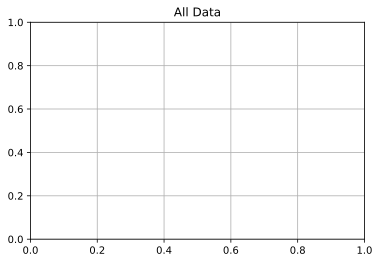

In [591]:

theFile = DataFile(os.getcwd() + "/IVs_NbO2_Ti0_Sam3_051823_D22.txt");
# theFile = DataFile(os.getcwd() + "/IVs_NbO2_Ti10_Sam3_042023_D18_try2edited.txt");
# theFile = DataFile(os.getcwd() + "/IVs_NbO2_Ti10_Sam3_042723_D18.txt");

theFile.graph_all_data()
# theFile.graph_temp()
# theFile.graph_r_vs_time()
current_threshold = 0.0001
# theFile.graph_current_at_voltage(0.2, current_threshold)
# theFile.graph_current_at_voltage(0.3, current_threshold)
# theFile.graph_current_at_voltage(0.4, current_threshold)
# theFile.graph_current_at_voltage(0.5, current_threshold)
# theFile.graph_r_vs_temps()

for x in range(8,10):
  number_of_runs = theFile.number_of_runs / 1.75
  i = (int)((number_of_runs / 12) * x)
  theFile.graph_IV_curve(i)


# for x in range(10):
#   number_of_runs = theFile.number_of_runs
#   i = (int)((number_of_runs / 12) * x)
#   print("temp: ", theFile.all_data_in_runs[x]['temp'], " std: ", theFile.all_data_in_runs[x]['temp_std'])
#   # print(theFile.all_data_in_runs[x])
#   theFile.graph_one_run(i)

# theFile.calculate_gradient_all_data()
# theFile.find_max_gradient()

# print(self.pos_hold_runs)
#         print(self.neg_hold_runs)
#         print(self.neg_thresh_runs)
#         print(self.pos_thresh_runs)

In [ ]:
# todo

# graph resistance vs temp
# temp vs current at 0.25 

# hold vs temp
# thresh vs temp



# path_to_data = os.getcwd() + "/data/" # the folder where all the data is stored
# files = [] # stores all the files data as DataFile objects

# # go into the data folder and extract all file names
# for path in os.listdir(path_to_data):
#   if os.path.isfile(os.path.join(path_to_data, path)):
#       files.append(DataFile(path_to_data + path))

# print("total files: ", len(files))
# print()

# files_to_graph = []

# for file in files:
#   if(len(file.device_temp) == 3):
#     if(file.device_number == "D18"):
#       files_to_graph.append(file)

# files_to_graph.sort(key=lambda x: x.device_temp)

# good_files = []
# for file in files_to_graph:
#   print(file.index)
#   good_files.append(file)

# for file in good_files:
#   file.graph_all_data()

  # print(file.index)

# 180k sam3 d18theFile.pos_hold_runs[0]
# 220k sam3 d18

# for x in range(12,14): 

# print(os.getcwd() + "/IVs_NbO2_Ti10_Sam3_042023_D18_try2.txt")


# print(len(theFile.temps))
# print((theFile.temps[6000:6100]))
# print(np.min(theFile.temps[6000:6100]))




# quarter_volt_indexes = []
# for x in range((int)(len(theFile.time) * (0/10)), (int)(len(theFile.time) * (10/10))):
#     if ((theFile.V[x] >= (voltage_to_graph - voltage_tolerance) and theFile.V[x] <= (voltage_to_graph + voltage_tolerance)) or (theFile.V[x] <= -(voltage_to_graph - voltage_tolerance) and self.V[x] >= -(voltage_to_graph + voltage_tolerance))):
#         quarter_volt_indexes.append(x)

# xAxis = []
# yAxis = []
# for x in quarter_volt_indexes:
#     xAxis.append(theFile.time[x])
#     yAxis.append(theFile.I[x])

# xAxis = np.array(xAxis)
# yAxis = np.array(yAxis)

# plt.title("current at " + str(voltage_to_graph) + " V")
# plt.rcParams['figure.figsize'] = (9,3)
# plt.grid()
# plt.plot(xAxis, yAxis)
# plt.xlabel('Time (s)')
# plt.ylabel('Voltage (V)')
# plt.figure(np.random.randint(1000000000))

# print(len(theFile.pos_runs))
# print(len(theFile.neg_runs))

# print(len(theFile.pos_thresh_runs))
# print(len(theFile.pos_hold_runs))
# print(len(theFile.neg_thresh_runs))
# print(len(theFile.neg_hold_runs))

print(len(theFile.pos_hold_voltages))
print(len(theFile.neg_hold_voltages))
print(len(theFile.pos_thresh_voltages))
print(len(theFile.neg_thresh_voltages))

1769
1765
1770
1767
